# 定性变量的处理

## 1. 目标要求
针对二元分类问题搭建逻辑回归模型，所采用数据是美国个人收入的普查数据,来源为美国加州大学欧文分校。在模型中加入定性变量，利用逻辑回归模型预测个人的年收入分类（>50k、<=50k）。

## 2. 数据探索分析：直观印象

In [115]:
from __future__ import print_function
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from patsy import ContrastMatrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic

In [116]:
# 读取数据
dataPath = "./data/adult.data"
data = pd.read_csv(dataPath)
data.head()

,age,workclass,fnlwgt,education,education_num,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [117]:
# 选取特定列的数据进行后续分析
cols = ["workclass","age", "sex","hours_per_week", "education_num", "capital_gain","capital_loss","label"]
data = data[cols]

利用pandas，将文本型类型变量转化为数字变量

在源数据的基础上新生成一个变量“label_code”,根据label的不同取值对应生成，共有两个取值：0表示“ <=50K ”，1表示“ >50K ”。

In [118]:
data["label_code"] = pd.Categorical(data['label']).codes
data.head()

,workclass,age,sex,hours_per_week,education_num,capital_gain,capital_loss,label,label_code
0,State-gov,39,Male,40,13,2174,0,<=50K,0
1,Self-emp-not-inc,50,Male,13,13,0,0,<=50K,0
2,Private,38,Male,40,9,0,0,<=50K,0
3,Private,53,Male,40,7,0,0,<=50K,0
4,Private,28,Female,40,13,0,0,<=50K,0


** 各变量的分布情况 **

采用直方图（histogram）将变量的分布情况可视化

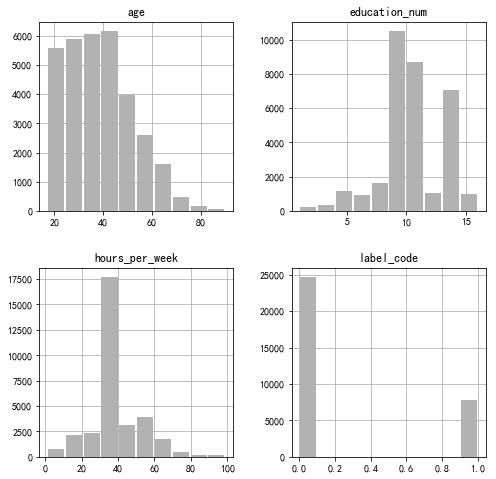

In [119]:
# 画直方图，直观了解数据
data[["age", "hours_per_week", "education_num", "label_code"]].hist(
        rwidth=0.9, figsize=(8, 8), alpha=0.6, color="grey")
plt.show()

**利用统计指标分析数据**

数据的基本统计信息，如平均值、标准差、极值等

In [120]:
data.describe()

,age,hours_per_week,education_num,capital_gain,capital_loss,label_code
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,40.437456,10.080679,1077.648844,87.303830,0.240810
std,13.640433,12.347429,2.572720,7385.292085,402.960219,0.427581
min,17.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,28.000000,40.000000,9.000000,0.000000,0.000000,0.000000
50%,37.000000,40.000000,10.000000,0.000000,0.000000,0.000000
75%,48.000000,45.000000,12.000000,0.000000,0.000000,0.000000
max,90.000000,99.000000,16.000000,99999.000000,4356.000000,1.000000


利用交叉报表（crosstab）来描述两个变量之间的关系

显示education_num, label交叉报表：
label           <=50K   >50K
education_num               
(0.9, 9.0]      12835   1919
(9.0, 10.0]      5904   1387
(10.0, 12.0]     1823    626
(12.0, 16.0]     4158   3909
显示hours_per_week, label交叉报表：
label              <=50K      >50K
hours_per_week                    
(0.902, 20.6]   0.933402  0.066598
(20.6, 40.2]    0.810991  0.189009
(40.2, 59.8]    0.599200  0.400800
(59.8, 79.4]    0.584670  0.415330
(79.4, 99.0]    0.648094  0.351906


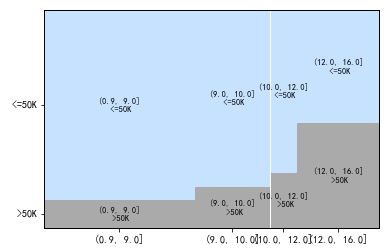

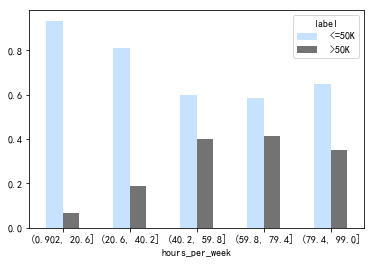

In [121]:
# 计算education_num, label交叉报表
cross1 = pd.crosstab(pd.qcut(data["education_num"],  q=[0, .25, .5, .75, 1], precision=1), data["label"])
print("显示education_num, label交叉报表：")
print(cross1)
# 将交叉报表图形化
props = lambda key: {"color": "#aaaaaa" if ' >50K' in key else "#C6E2FF"}
mosaic(cross1[[" >50K", " <=50K"]].stack(), properties=props)
# 计算hours_per_week, label交叉报表
cross2 = pd.crosstab(pd.cut(data["hours_per_week"], 5), data["label"])
# 将交叉报表归一化，利于分析数据
cross2_norm = cross2.div(cross2.sum(1).astype(float), axis=0)
print("显示hours_per_week, label交叉报表：")
print(cross2_norm)
# 图形化归一化后的交叉报表
cross2_norm.plot(kind="bar", color=["#C6E2FF", "0.45"], rot=0)
plt.show()

显示sex, label交叉报表：
label     <=50K   >50K
sex                   
 Female    9592   1179
 Male     15128   6662


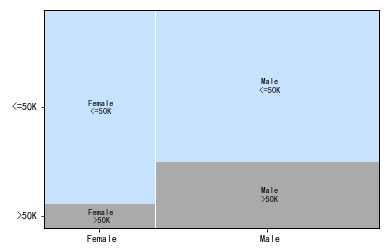

In [122]:
# 计算sex, label交叉报表
cross1 = pd.crosstab(data["sex"], data["label"])
print("显示sex, label交叉报表：")
print(cross1)
# 将交叉报表图形化
props = lambda key: {"color": "#aaaaaa" if ' >50K' in key else "#C6E2FF"}
mosaic(cross1[[" >50K", " <=50K"]].stack(), properties=props)
plt.show()

### 1.2 搭建模型

**使用第三方库Statsmodels搭建模型，并利用统计学方法分析模型参数估计值的稳定性**

分别定义基础逻辑回归模型和包含定性变量的逻辑回归模型

In [123]:
def baseModel(data):
    """
    原有基础逻辑回归模型
    """
    formula = "label_code ~ education_num + capital_gain + capital_loss + hours_per_week"
    model = sm.Logit.from_formula(formula, data=data)
    re = model.fit()
    return re

In [124]:
def trainModel(data):
    """
    加入一个定性变量来搭建逻辑回归模型
    """
    formula = "label_code ~ C(sex) + education_num + capital_gain + capital_loss + hours_per_week"
    model = sm.Logit.from_formula(formula, data=data)
    re = model.fit()
    return re

In [149]:
from patsy import ContrastMatrix

def trainModel2(data):
    """
    加入"workclass"定性变量（含有多个类别）来搭建逻辑回归模型
    """
    l = [' ?', ' Without-pay', ' Never-worked',' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc']
    
    contrast = np.eye(9,6,k=-3)
    
    contrast_mat = ContrastMatrix(contrast, l[3:])
    
    formula = "label_code ~ C(workclass, contrast_mat, levels=l) + C(sex) + education_num + capital_gain + capital_loss + hours_per_week"
    model = sm.Logit.from_formula(formula, data=data)
    re = model.fit()
    return re

In [125]:
def modelSummary(re):
    """
    分析逻辑回归模型的统计性质
    """
    # 整体统计分析结果
    print(re.summary())

In [126]:
# 将数据分为训练集和测试集
trainSet, testSet = train_test_split(data, test_size=0.2, random_state=2310)

In [127]:
# 训练模型并分析基础逻辑回归模型效果
baseModelRe = baseModel(trainSet)
modelSummary(baseModelRe)

Optimization terminated successfully.
         Current function value: 0.426128
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26043
Method:                           MLE   Df Model:                            4
Date:                Thu, 08 Nov 2018   Pseudo R-squ.:                  0.2276
Time:                        21:54:50   Log-Likelihood:                -11100.
converged:                       True   LL-Null:                       -14370.
                                        LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -6.4633      0.105    -61.684      0.000      -6.669      -6.258
education_num    

In [128]:
# 训练模型并分析包含一个定性变量的逻辑回归模型效果
model = trainModel(trainSet)
modelSummary(model)

Optimization terminated successfully.
         Current function value: 0.409236
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26042
Method:                           MLE   Df Model:                            5
Date:                Thu, 08 Nov 2018   Pseudo R-squ.:                  0.2582
Time:                        21:54:51   Log-Likelihood:                -10660.
converged:                       True   LL-Null:                       -14370.
                                        LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -7.1944      0.112    -64.011      0.000      -7.415      -6.974
C(sex)[T. Male

In [150]:
model2 = trainModel2(trainSet)
modelSummary(model2)

Optimization terminated successfully.
         Current function value: 0.405935
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26036
Method:                           MLE   Df Model:                           11
Date:                Thu, 08 Nov 2018   Pseudo R-squ.:                  0.2642
Time:                        22:07:52   Log-Likelihood:                -10574.
converged:                       True   LL-Null:                       -14370.
                                        LLR p-value:                     0.000
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept             

### 1.4 评估模型效果

**查准率与查全率**

In [129]:
def makePrediction(re, testSet, alpha=0.5):
    """
    使用训练好的模型对测试数据做预测
    """
    # 关闭pandas有关chain_assignment的警告
    pd.options.mode.chained_assignment = None
    # 计算事件发生的概率
    data = testSet.copy()
    data["prob"] = re.predict(data)
    print("事件发生概率（预测概率）大于0.6的数据个数：")
    print(data[data["prob"] > 0.6].shape[0])  # 输出值为576
    print("事件发生概率（预测概率）大于0.5的数据个数：")
    print(data[data["prob"] > 0.5].shape[0])  # 输出值为834
    # 根据预测的概率，得出最终的预测
    data["pred"] = data.apply(lambda x: 1 if x["prob"] > alpha else 0, axis=1)
    return data

In [130]:
def evaluation(re):
    """
    计算预测结果的查准查全率以及f1

    参数
    ----
    re ：DataFrame，预测结果，里面包含两列：真实值‘lable_code’、预测值‘pred’
    """
    bins = np.array([0, 0.5, 1])
    label = re["label_code"]
    pred = re["pred"]
    tn, fp, fn, tp = np.histogram2d(label, pred, bins=bins)[0].flatten()
    print('tp:',tp,'fp:',fp,'fn:',fn,'tn:',tn)
    precision = tp / (tp + fp)  # 0.951
    recall = tp / (tp + fn)  # 0.826
    f1 = 2 * precision * recall / (precision + recall)  # 0.884
    print("查准率: %.3f, 查全率: %.3f, f1: %.3f" % (precision, recall, f1))

In [131]:
# 基础逻辑回归模型的预测效果
baseTestSet = makePrediction(baseModelRe, testSet)
evaluation(baseTestSet)
baseTestSet.head()

事件发生概率（预测概率）大于0.6的数据个数：
495
事件发生概率（预测概率）大于0.5的数据个数：
659
tp: 492.0 fp: 167.0 fn: 1084.0 tn: 4770.0
查准率: 0.747, 查全率: 0.312, f1: 0.440


,workclass,age,sex,hours_per_week,education_num,capital_gain,capital_loss,label,label_code,prob,pred
19463,Private,55,Male,40,9,0,0,<=50K,0,0.113848,0
24430,Private,38,Female,40,10,0,0,<=50K,0,0.150374,0
19621,Private,36,Male,60,11,0,0,<=50K,0,0.343604,0
3862,Private,41,Male,48,11,0,1848,>50K,1,0.576574,1
27549,?,20,Female,40,10,0,0,<=50K,0,0.150374,0


In [132]:
testSet.head()

,workclass,age,sex,hours_per_week,education_num,capital_gain,capital_loss,label,label_code
19463,Private,55,Male,40,9,0,0,<=50K,0
24430,Private,38,Female,40,10,0,0,<=50K,0
19621,Private,36,Male,60,11,0,0,<=50K,0
3862,Private,41,Male,48,11,0,1848,>50K,1
27549,?,20,Female,40,10,0,0,<=50K,0


In [133]:
# 包含定性变量的逻辑回归模型的预测效果
testSet = makePrediction(model, testSet)
evaluation(testSet)

事件发生概率（预测概率）大于0.6的数据个数：
545
事件发生概率（预测概率）大于0.5的数据个数：
764
tp: 577.0 fp: 187.0 fn: 999.0 tn: 4750.0
查准率: 0.755, 查全率: 0.366, f1: 0.493


In [134]:
testSet.head()

,workclass,age,sex,hours_per_week,education_num,capital_gain,capital_loss,label,label_code,prob,pred
19463,Private,55,Male,40,9,0,0,<=50K,0,0.148673,0
24430,Private,38,Female,40,10,0,0,<=50K,0,0.066970,0
19621,Private,36,Male,60,11,0,0,<=50K,0,0.386100,0
3862,Private,41,Male,48,11,0,1848,>50K,1,0.634381,1
27549,?,20,Female,40,10,0,0,<=50K,0,0.066970,0


**ROC曲线与AUC**

In [135]:
from sklearn import metrics

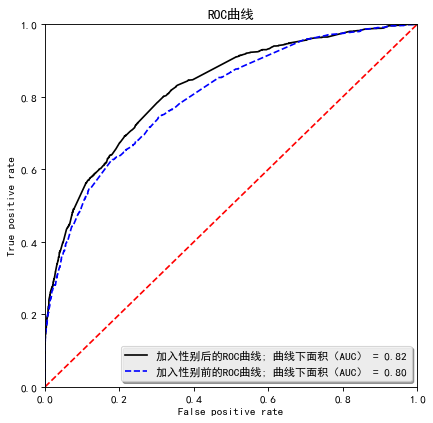

In [136]:
fpr, tpr, thresholds = metrics.roc_curve(testSet['label_code'], testSet['prob'])
auc = metrics.auc(fpr,tpr)
# 为在Matplotlib中显示中文，设置特殊字体
plt.rcParams["font.sans-serif"]=["SimHei"]
# 创建一个图形框
fig = plt.figure(figsize=(6, 6), dpi=80)
# 在图形框里只画一幅图
ax = fig.add_subplot(1, 1, 1)
ax.set_title("%s" % "ROC曲线".decode("utf-8"))
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, "k", label="%s; %s = %0.2f" % ("加入性别后的ROC曲线".decode("utf-8"),"曲线下面积（AUC）".decode("utf-8"), auc))
fpr, tpr, thresholds = metrics.roc_curve(testSet['label_code'], baseTestSet['prob'])
auc = metrics.auc(fpr,tpr)
ax.plot(fpr, tpr, "b--", label="%s; %s = %0.2f" % ("加入性别前的ROC曲线".decode("utf-8"),"曲线下面积（AUC）".decode("utf-8"), auc))
legend = plt.legend(shadow=True)
plt.show()

In [138]:
data['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked'], dtype=object)